# Objective: Analysing the effects of Demonetisation on Digital Payments
# Data Source: RBI 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import gc
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression as lr

In [2]:
## Extract debit card related data in data_debit
data_rbi1 = pd.read_excel("RBIB1.xlsx", header=1)
data_rbi1 = data_rbi1.reset_index()
data_rbi1 = data_rbi1.drop(columns= "index")
data_rbi1 = data_rbi1.drop(0)

data_debit = data_rbi1[['Month/Year','     5.2  Debit Cards','Unnamed: 52','            5.2.1  Usage at ATMs', 'Unnamed: 54',  '            5.2.2  Usage at POS', 'Unnamed: 56']]
data_debit.columns=['Month/Year','Debit_Cards_Volume','Debit_Cards_Value','ATM_Volume','ATM_Value','POS_Volume','POS_Value']
data_debit=data_debit.drop([167,168])
# fill missing values 
data_debit.ATM_Volume=data_debit.ATM_Volume.fillna(0)
data_debit.ATM_Volume=data_debit.ATM_Volume.apply(lambda x:x if x!='–' else 0)

data_debit.ATM_Value=data_debit.ATM_Value.fillna(0)
data_debit.ATM_Value=data_debit.ATM_Value.apply(lambda x:x if x!='–' else 0)

# Make date features
data_debit['Month']=data_debit['Month/Year'].apply(lambda x:x.split('-')[0])
data_debit['Year']=data_debit['Month/Year'].apply(lambda x:x.split('-')[1])
month_dict={
        'Jan' : '01',
        'Feb' : '02',
        'Mar' : '03',
        'Apr' : '04',
        'May' : '05',
        'Jun' : '06',
        'Jul' : '07',
        'Aug' : '08',
        'Sep' : '09', 
        'Oct' : '10',
        'Nov' : '11',
        'Dec' : '12'
}
data_debit['Month']=data_debit['Month'].apply(lambda x:month_dict[x])
data_debit['Date']=data_debit.apply(lambda x: str(x.Month)+'/'+str(x.Year),axis=1)
data_debit['Date']=pd.to_datetime(data_debit.Date,format='%m/%Y')

In [3]:
def p_q(s):
    lag_acf = acf(s, nlags=50)
    lag_pacf = pacf(s, nlags=50, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(s)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(s)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(s)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(s)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    return

In [16]:
# linear regression
def lr_model(col_name,raw=True):
    min_date=data_debit[(data_debit.ATM_Value>0)]['Date'].min()
    max_date=data_debit.Date.iloc[25]
    train=pd.DataFrame()
    train['counter']=(data_debit.Date-min_date).dt.days
    train['month']=data_debit.Month
    train['year']=data_debit.Year
    train['target']=data_debit[col_name].values
    train.index=data_debit.Date
    train_dates=(train.index>min_date) &(train.index<max_date)
    test_dates=(train.index > max_date)
    model=lr()
    model.fit(X=train[train_dates][['counter','month','year']].values,y=train[train_dates]['target'].values)
    train['predict']=model.predict(train[['counter','month','year']])
    if not raw:
        train[['target','predict']].plot(figsize=(6, 4))
        print('RMSE: '+str(np.sqrt(np.mean((train['target'][test_dates]-train['predict'][test_dates])**2))))
        return  
    else:
        return train
    

def log_lr_model(col_name,raw=True):
    min_date=data_debit.Date.min()
    max_date=data_debit.Date.iloc[25]
    train=pd.DataFrame()
    train['counter']=(data_debit.Date-min_date).dt.days
    train['month']=data_debit.Month
    train['year']=data_debit.Year
    train['target']=data_debit[col_name].values
    train.index=data_debit.Date
    train_dates=(train.index>min_date) &(train.index<max_date)
    test_dates=(train.index > max_date)
    model=lr()
    model.fit(X=train[train_dates][['counter']].values,y=np.log(train[train_dates]['target'].values))
    train['predict']=np.exp(model.predict(train[['counter']]))
    new_train=pd.DataFrame()
    new_train['Date']=pd.date_range(train.index.max(),'01-01-2021',freq='M')
    new_train.index=new_train.Date
    new_train['counter']=(new_train.Date-min_date).dt.days
    new_train['month']=new_train.Date.dt.month
    new_train['year']=new_train.Date.dt.year
    new_train['predict']=np.exp(model.predict(new_train[['counter']]))
    train=pd.concat([train[['predict','target']],new_train[['predict']]])
    return train

# ATM Cash Withdrawals (Value and Volume)

Blue line is a simulated scenario without demonetisation.

>We can see that demonetisation was just a transient event in the case of ATM transactions, the current cash withdrawals have already caught up with the Blue line.

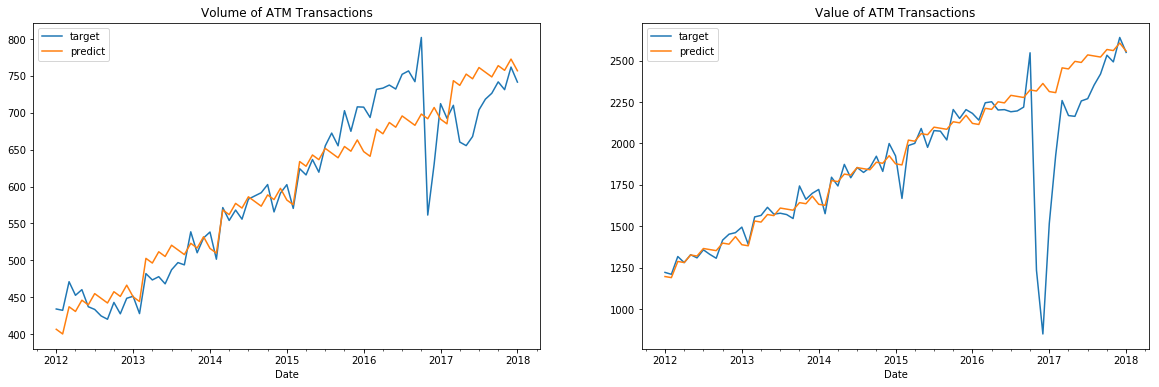

In [17]:
fig, ax= plt.subplots(1,2,figsize=(20,6))
train=lr_model('ATM_Volume')
train[train.index>='01-01-2012'][['target','predict']].plot(ax=ax[0])
ax[0].title.set_text('Volume of ATM Transactions')

train=lr_model('ATM_Value')
train[train.index>='01-01-2012'][['target','predict']].plot(ax=ax[1])
ax[1].title.set_text('Value of ATM Transactions')

# Point of Sale Transactions (Value and Volume)

POS transactions in the RBI data include debit cards, credit cards and mobile payments, it doesn't include cash 

Blue line is a simulated scenario without demonetisation.


>Digital payments in india were increasing exponentially before demonetisation.
>Even in the case of digital payments, demonetisation has created a transient change which is likely to catch up with the blue line.

/home/developer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



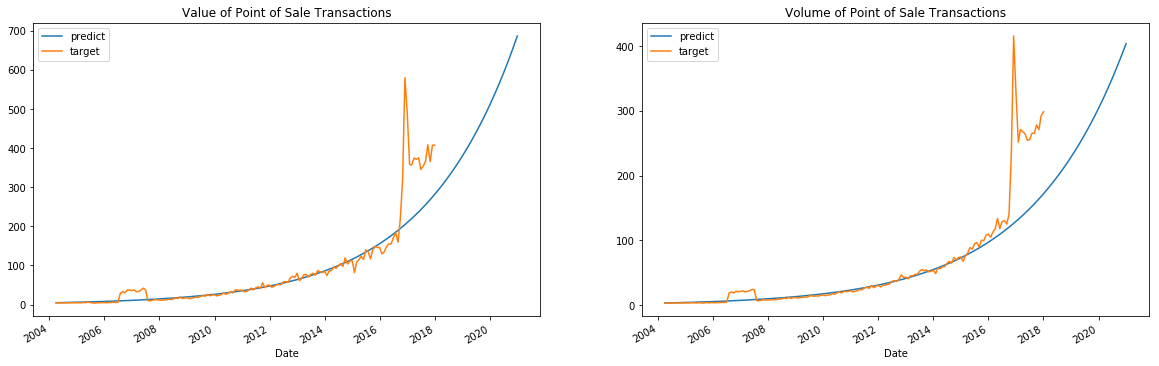

In [18]:
fig, ax= plt.subplots(1,2,figsize=(20,6))

train=log_lr_model('POS_Value')
train[['predict','target']].plot(ax=ax[0])
ax[0].title.set_text('Value of Point of Sale Transactions')

train=log_lr_model('POS_Volume')
train[['predict','target']].plot(ax=ax[1])
ax[1].title.set_text('Volume of Point of Sale Transactions')